- Take only the wind speed for r > Rmax / 2. Close to 0, the Holland wind profile exagerates the plateau of minimum wind speed (U-shape)

In [59]:
# General
import os
import glob

# Display
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.gridspec import GridSpec
import matplotlib.cm as cm

# Data treatment
import xarray as xr
import numpy as np
# from scipy.interpolate import griddata
import pandas as pd 
from tqdm import tqdm
import ephem

# Default parameters
fontsize = 16
mpl.rcParams.update({'font.size': fontsize})
mpl.rcParams['figure.figsize'] = (15, 10)
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'

In [60]:
### Paths & Params
PTHS = {
    'sar_pth': '/home/arthur/results/sar_extended/05_addPRIMED/dsg.nc',
}

### Open data
dsg  = xr.open_dataset(PTHS['sar_pth'])

In [61]:
### FUNCTIONS
def holland_profile(r, lat, B, Vmin, Rmax, Vmax):
    '''We assume that rho is constant and equals 1.15 kg.m-3'''
    fcor   = abs(coriolis(lat))
    rho    = 1.15
    r      = r.astype(float) + 0.001           # To avoid dividing by zero
    r_star = (Rmax / r) ** B
    V      = r * 0.
    V      = Vmin + np.sqrt( ((Vmax - Vmin) ** 2) * r_star * np.exp(1 - r_star) + (r * fcor / 2) ** 2) - (r * fcor / 2)
    return V

def coriolis(lat):
    '''Latitude must be in degrees.'''
    Omega = 7.2921e-5                             # Earth rotation vector
    fcor  = 2 * Omega * np.sin(lat * np.pi / 180) # Coriolis parameter assuming it's constant 
    return fcor

rs = np.linspace(10, 500000, 50000) # define dr accordingly
dr = 10 # meters
def vorticity(r, v):
    '''Relative vorticity'''
    return (1 / (r + 0.000001)) * np.gradient(r * v, dr)

def w_ekman(r, v, fcr, Cd=2.5e-3):
    '''Ekman vertical velocity'''
    rvor = vorticity(r, v)
    num  = Cd * r * (v ** 2)
    den  = rvor + fcr
    return (1 / (r + 0.000001)) * np.gradient(num / den, dr)

In [62]:
# FILTERS
cond = (
    (dsg.center_quality_flag < 2) & 
    (dsg.percent_outside < 50) & 
    (dsg.percent_rmx_inside == 1) &
    (abs(dsg.lat) < 30) & 
    (dsg.rmx < 100000) & 
    (dsg.vmx > 20)
)
df   = dsg.where(cond, drop=True)
print(len(df.time))

529


In [117]:
d = df.isel(time=-1)

In [118]:
# Fixed parameters
vmx = float(d.vmx_hol)
rmx = float(d.rmx_hol)
vmn = float(d.vmn_hol)
B   = float(d.B_hol)
lat = float(d.lat)
fcr = abs(float(d.fcor))
Ut  = float(d.speed)

# Holland with fixed parameters
V   = holland_profile(rs, lat, B, vmn, rmx, vmx)
w   = w_ekman(rs, V, fcr)

(0.0, 100000.0)

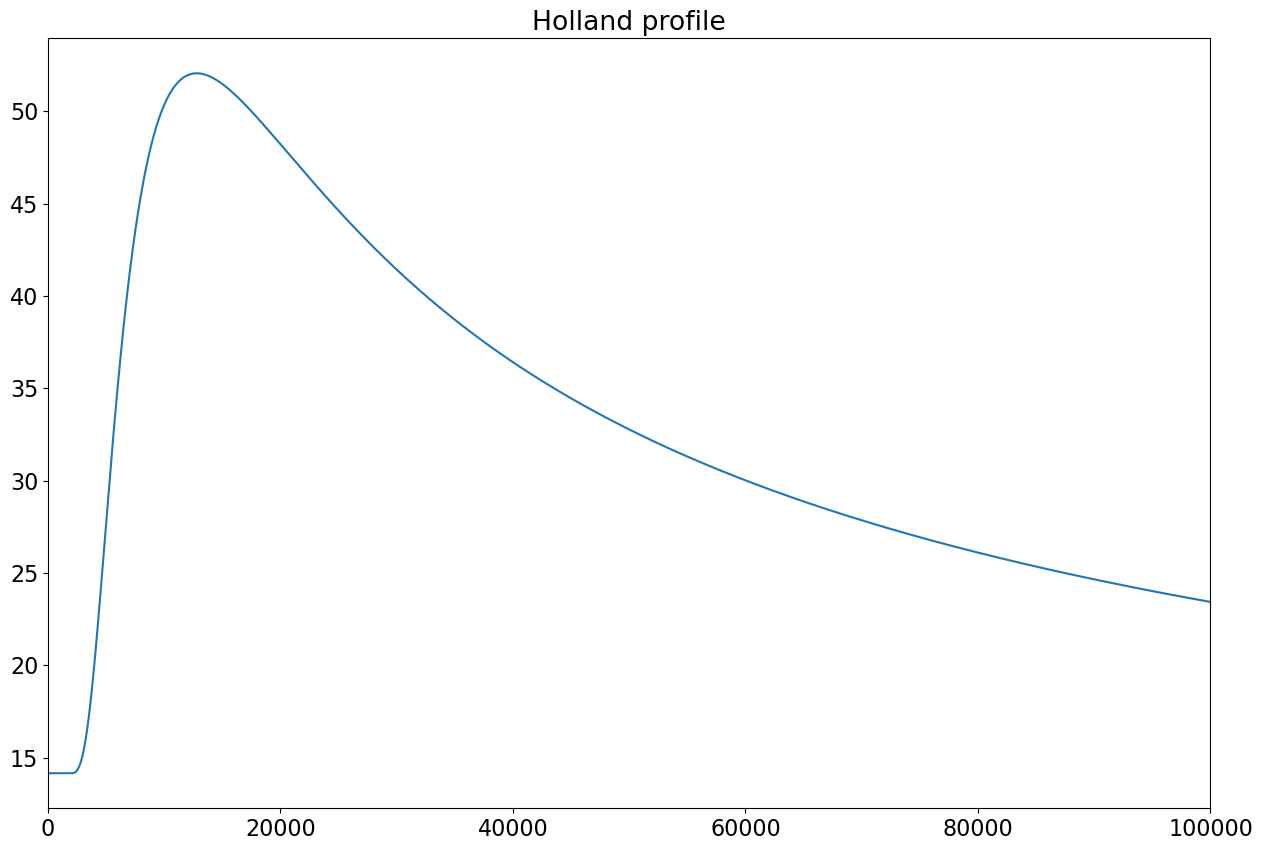

In [119]:
plt.title('Holland profile')
plt.plot(rs, V)
plt.xlim(0, 100000)

(0.0, 100000.0)

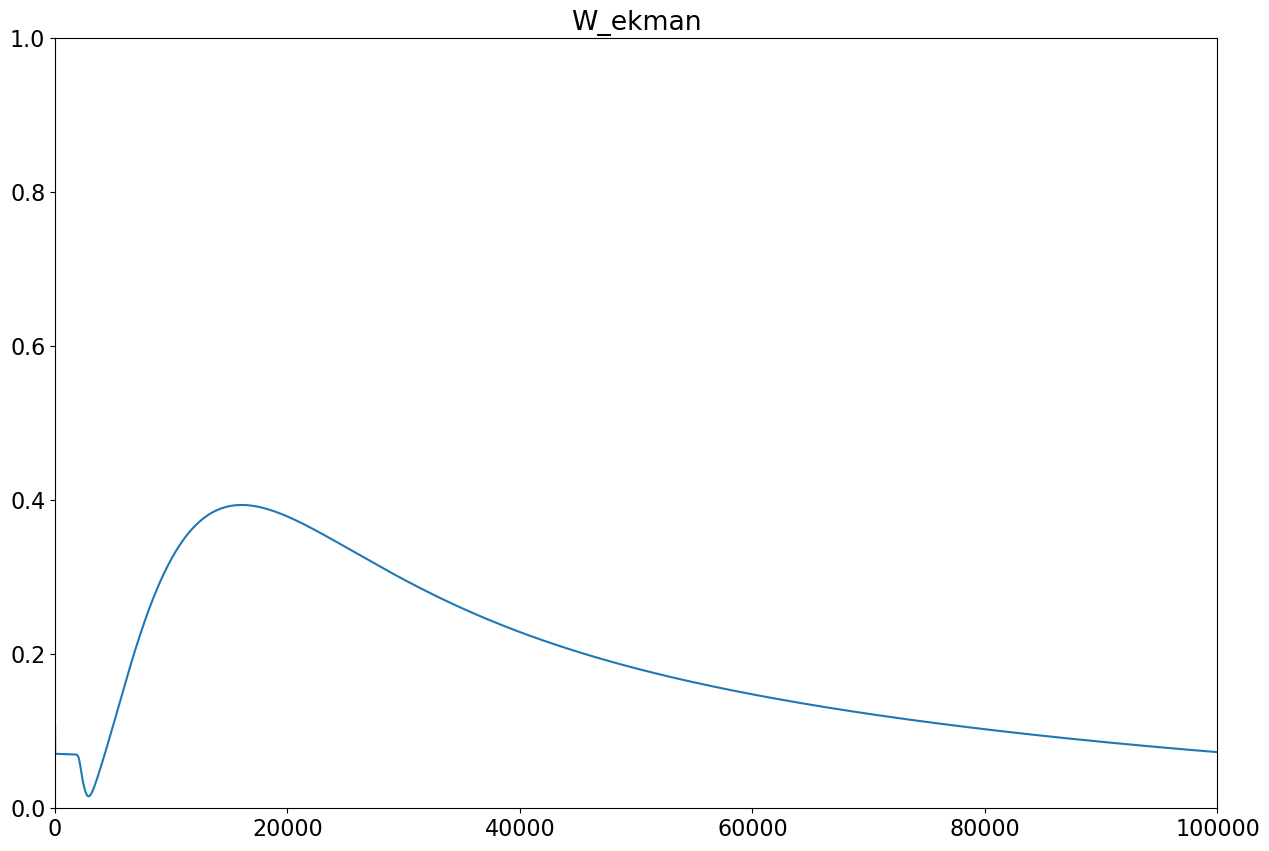

In [120]:
plt.title('W_ekman')
plt.plot(rs, w)
plt.ylim(0, 1)
# plt.xlim(-10000, 50000)
plt.xlim(0, 100000)

In [121]:
w

array([0.10610226, 0.07073203, 0.07072767, ..., 0.01363107, 0.01372335,
       0.01381559], shape=(50000,))

(0.0, 100000.0)

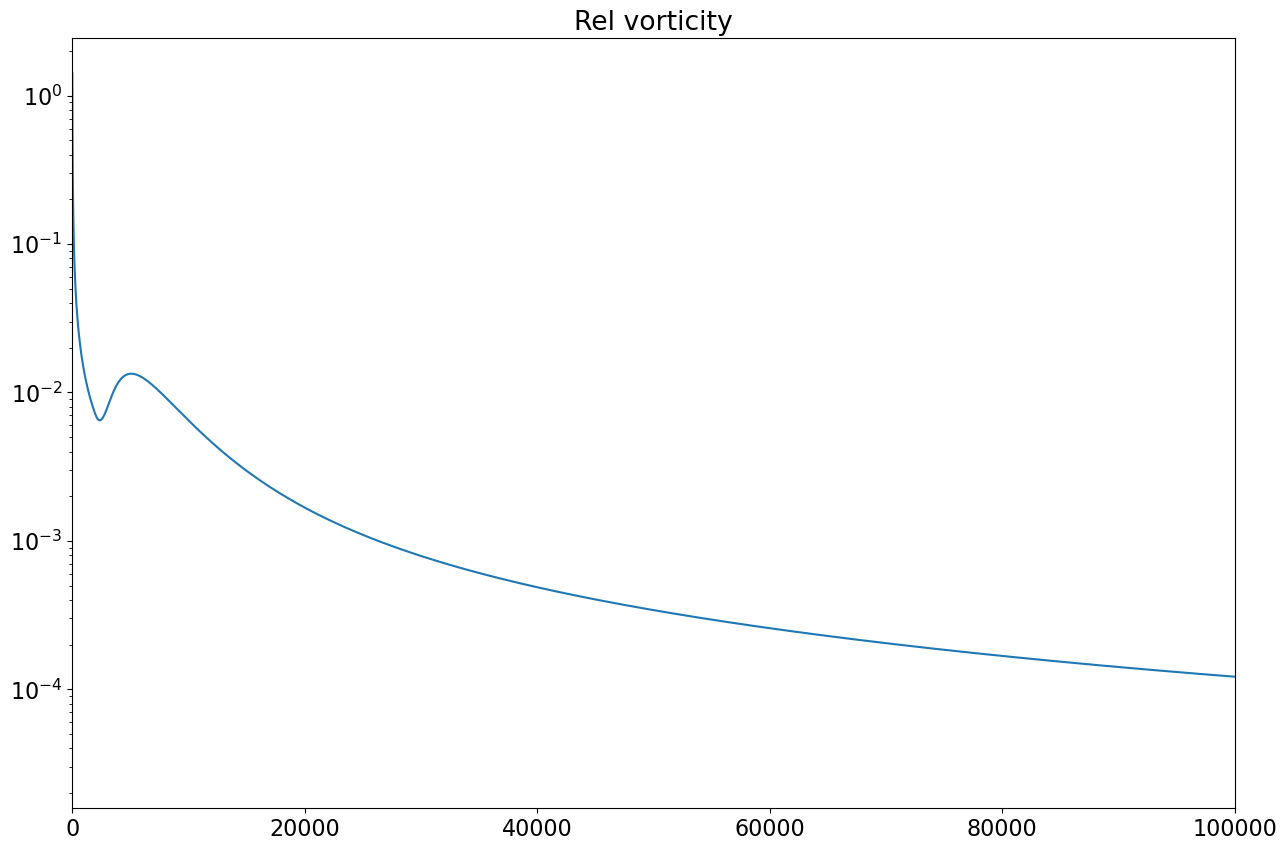

In [122]:
rvor = vorticity(rs, V)
plt.title('Rel vorticity')
plt.plot(rs, rvor)
plt.yscale('log')
plt.xlim(0, 100000)

In [123]:
num = 2.5e-3 * rs * (V ** 2)

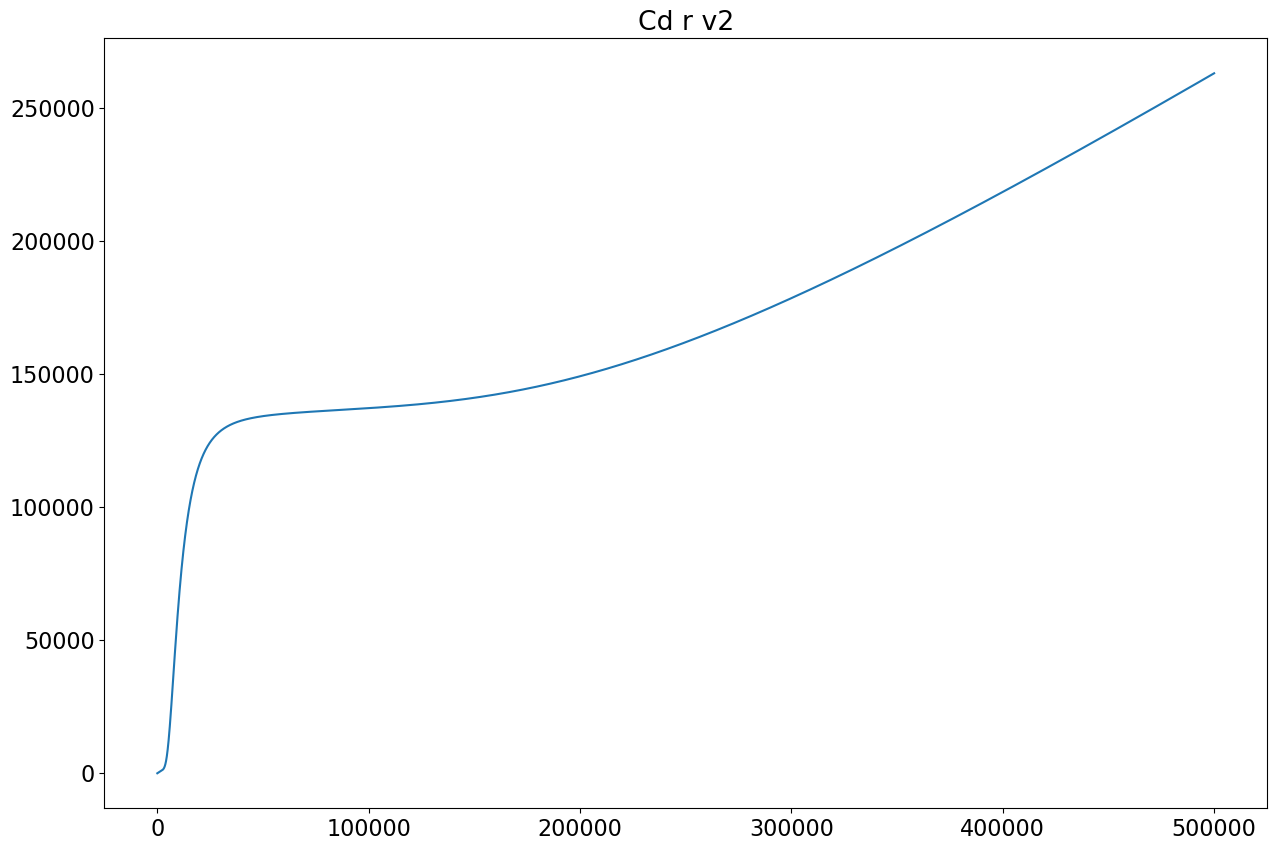

In [124]:
plt.title('Cd r v2')
plt.plot(rs, num)

In [125]:
den = w + fcr

(0.0, 100000.0)

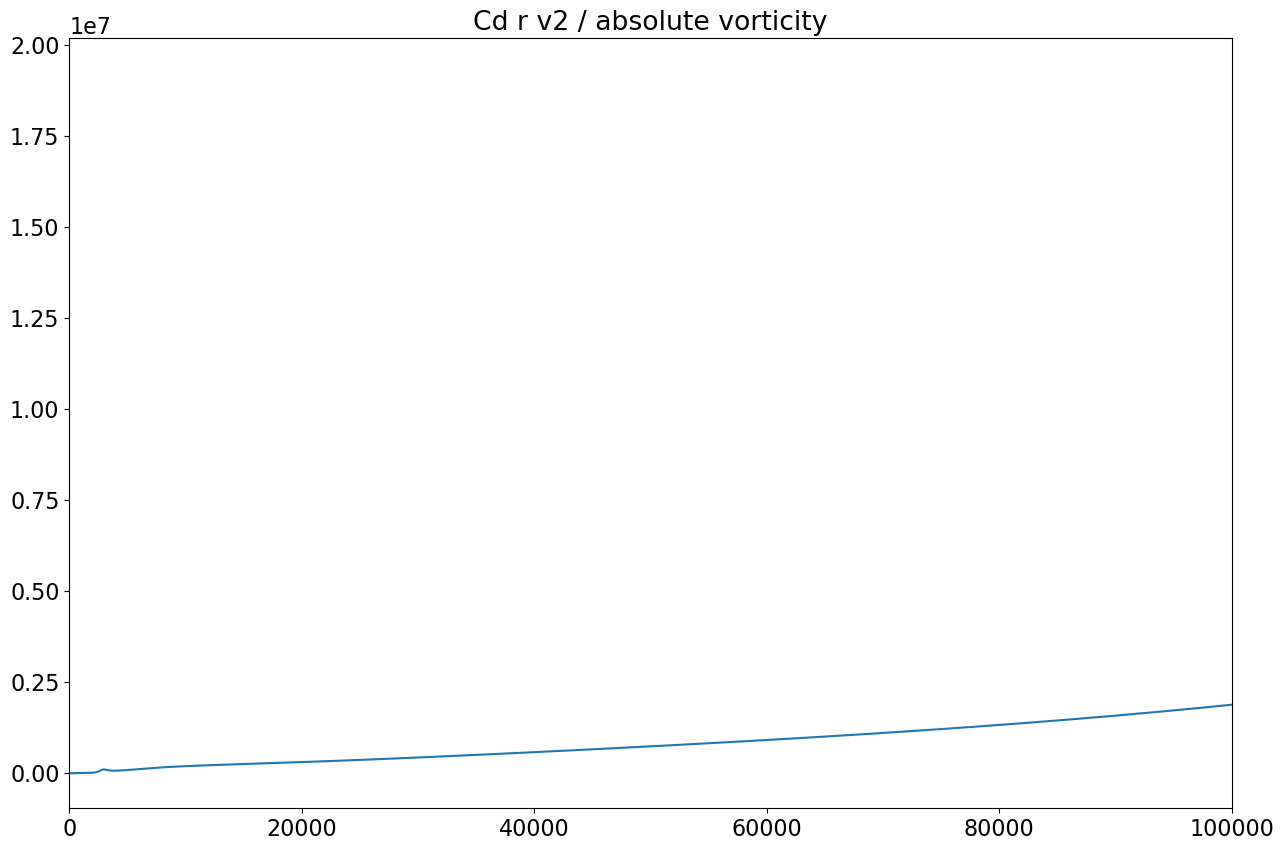

In [126]:
plt.title('Cd r v2 / absolute vorticity')
plt.plot(rs, num / den)
plt.xlim(0, 100000)